# Kriging the cantilever beam model


In this example, we create a kriging metamodel of the cantilever beam. We use a squared exponential covariance model for the kriging. In order to estimate the hyper-parameters, we use a design of experiments which size is 20. 

We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end of the cantilever beam is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a deviation $Y$. 

<img src="beam.png" width="200">

**Inputs**

* $E$ : Young modulus (Pa), Beta($\alpha = 0.9$, $\beta = 2.27$, a = $2.5\times 10^7$, $b = 5\times 10^7$)
* $F$ : Loading (N), Lognormal($\mu_F=30 \times 10^3$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)
* $L$ : Length of beam (cm), Uniform(min=250.0, max= 260.0)
* $I$ : Moment of inertia (cm^4), Beta($\alpha = 2.5$, $\beta = 1.5$, a = 310, b = 450).

In the previous table $\mu_F=E(F)$ and $\sigma_F=\sqrt{V(F)}$ are the mean and the standard deviation of $F$.

We assume that the random variables E, F, L and I are dependent and associated with a gaussian copula which correlation matrix is :
$$
R = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & -0.2 \\
0 & 0 & -0.2 & 1
\end{pmatrix}
$$

In other words, we consider that the variables L and I are negatively correlated : when the length L increases, the moment of intertia I decreases.

**Output**

The vertical displacement at free end of the cantilever beam is:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$


## Definition of the model

In [1]:
import openturns as ot

We define the symbolic function which evaluates the output Y depending on the inputs E, F, L and I.

In [2]:
model = ot.SymbolicFunction(["E", "F", "L", "I"], ["F*L^3/(3*E*I)"])

Then we define the distribution of the input random vector. 

In [3]:
# Young's modulus E
E = ot.Beta(0.9, 2.27, 2.5e7, 5.0e7) # in N/m^2
E.setDescription("E")
# Load F
F = ot.LogNormal() # in N
F.setParameter(ot.LogNormalMuSigma()([30.e3, 9e3, 15.e3]))
F.setDescription("F")
# Length L
L = ot.Uniform(250., 260.) # in cm
L.setDescription("L")
# Moment of inertia I
I = ot.Beta(2.5, 1.5, 310, 450) # in cm^4
I.setDescription("I")

Finally, we define the dependency using a `NormalCopula`.

In [4]:
dim = 4 # number of inputs
R = ot.CorrelationMatrix(dim)
R[2, 3] = -0.2 
myCopula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(R))
myDistribution = ot.ComposedDistribution([E, F, L, I], myCopula)

## Create the design of experiments

We consider a simple Monte-Carlo sampling as a design of experiments. This is why we generate an input sample using the `getSample` method of the distribution. Then we evaluate the output using the `model` function.

In [5]:
sampleSize_train = 20
X_train = myDistribution.getSample(sampleSize_train)
Y_train = model(X_train)

The following figure presents the distribution of the vertical deviations Y on the training sample. We observe that the large deviations occur less often. 

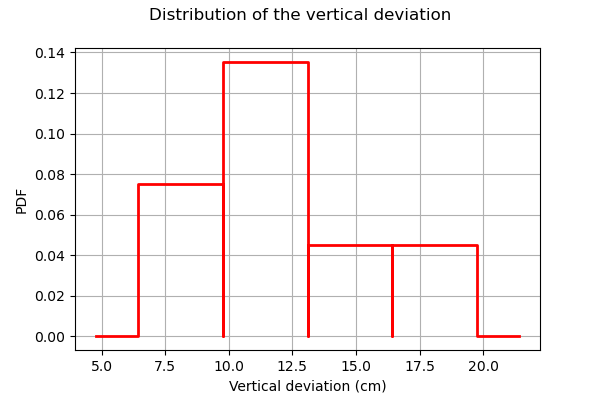

In [6]:
histo = ot.HistogramFactory().build(Y_train).drawPDF()
histo.setXTitle("Vertical deviation (cm)")
histo.setTitle("Distribution of the vertical deviation")
histo.setLegends([""])
histo

## Create the metamodel

In order to create the kriging metamodel, we first select a constant trend with the `ConstantBasisFactory` class. Then we use a squared exponential covariance model. Finally, we use the `KrigingAlgorithm` class to create the kriging metamodel, taking the training sample, the covariance model and the trend basis as input arguments. 

In [7]:
dimension = myDistribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.]*dimension, [1.0])
algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
krigingMetamodel = result.getMetaModel()

The `run` method has optimized the hyperparameters of the metamodel. 

We can then print the constant trend of the metamodel, which have been estimated using the least squares method.

In [8]:
result.getTrendCoefficients()

[class=Point name=Unnamed dimension=1 values=[18.7495]]

We can also print the hyperparameters of the covariance model, which have been estimated by maximizing the likelihood. 

In [9]:
result.getCovarianceModel()

class=SquaredExponential scale=class=Point name=Unnamed dimension=4 values=[5.49182,5.18332,7.19611,6.86906] amplitude=class=Point name=Unnamed dimension=1 values=[8.37795]

## Validate the metamodel

We finally want to validate the kriging metamodel. This is why we generate a validation sample which size is equal to 100 and we evaluate the output of the model on this sample.

In [10]:
sampleSize_test = 100
X_test = myDistribution.getSample(sampleSize_test)
Y_test = model(X_test)

The `MetaModelValidation` classe makes the validation easy. To create it, we use the validation samples and the metamodel. 

In [11]:
val = ot.MetaModelValidation(X_test, Y_test, krigingMetamodel)

The `computePredictivityFactor` computes the Q2 factor. 

In [12]:
Q2 = val.computePredictivityFactor()
Q2

0.9645762691321285

Since the Q2 is larger than 95%, we can say that the quality is acceptable. 

The residuals are the difference between the model and the metamodel. 

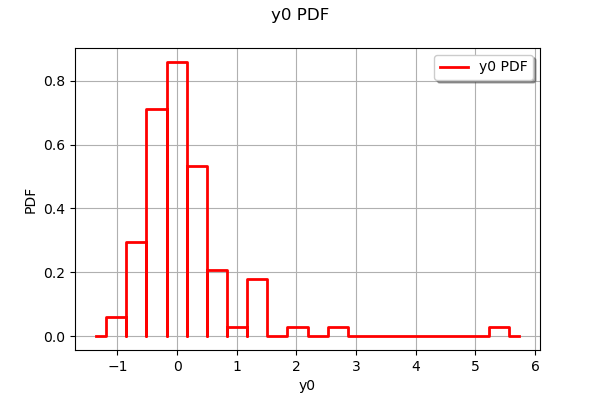

In [13]:
r = val.getResidualSample()
ot.HistogramFactory().build(r).drawPDF()

We observe that the negative residuals occur with nearly the same frequency of the positive residuals: this is a first   sign of good quality. Furthermore, the residuals are most of the times contained in the [-1,1] interval, which is a sign of quality given the amplitude of the output (approximately from 5 to 25 cm).

The `drawValidation` method allows to compare the observed outputs and the metamodel outputs.

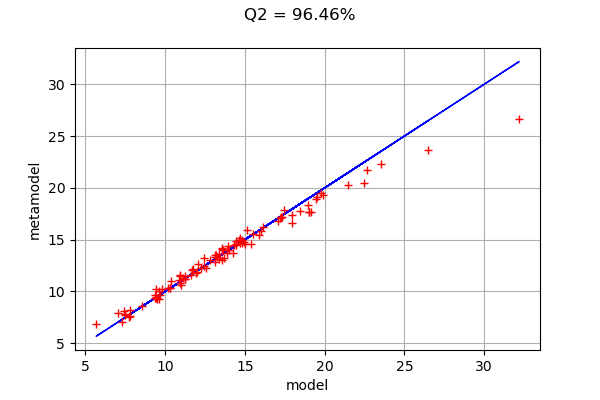

In [14]:
graph = val.drawValidation()
graph.setLegends([""])
graph.setTitle("Q2 = %.2f%%" % (100*Q2))
graph

We observe that the metamodel predictions are close to the model outputs, since most red points are close to the diagonal. However, when we consider extreme deviations (i.e. less than 10 or larger than 20), then the quality is less obvious.

Given that the kriging metamodel quality is sensitive to the design of experiments, it might be interesting to consider a Latin Hypercube Sampling (LHS) design to further improve the predictions quality.